In [66]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import pprint, init_printing, latex
from IPython.display import display, Math

In [113]:
def latex(matrix):
    M = sp.Matrix(matrix)
    M_exact = M.applyfunc(lambda x: sp.nsimplify(x, [sp.sqrt(3)]))
    display(Math(sp.latex(M_exact)))

def random_point_in_third_hexagon(v1, v2):
    u = np.random.rand()
    v = np.random.rand()
    return u * v1 + v * v2

In [75]:
theta, t1, t2 = sp.symbols('theta t1 t2', real=True)

g_matrix = sp.Matrix([
    [ sp.cos(theta), -sp.sin(theta), t1 ],
    [ sp.sin(theta),  sp.cos(theta), t2 ],
    [         0,          0,  1 ]
])

g_inv_matrix = g_matrix.inv()

# Lambdify to super-fast NumPy
g      = sp.lambdify((theta, t1, t2), g_matrix, 'numpy')
inverse = sp.lambdify((theta, t1, t2), g_inv_matrix, 'numpy')


In [86]:
# v1 = translation by (1,0)
v1_mat = g(0, 1, 0)
latex(v1_mat)

print("--------------------------------")

# v2 = translation by (–1/2, √3/2)
v2_mat = g(0, -0.5, np.sqrt(3)/2)
latex(v2_mat)

<IPython.core.display.Math object>

--------------------------------


<IPython.core.display.Math object>

In [88]:
gpi3     = g(2*np.pi/3, 0, 0)
gpi3_inv = inverse(2*np.pi/3, 0, 0)

gv2_mat = gpi3 @ v1_mat @ gpi3_inv
assert np.allclose(v2_mat, gv2_mat), "Conjugation by 120° failed to produce v2"

latex(gpi3)

<IPython.core.display.Math object>

In [102]:
gpi12     = g(np.pi/12, 0, 0)
gpi12_inv = inverse(np.pi/12, 0, 0)

gc1 = gpi12 @ v1_mat @ gpi12_inv
gc2 = gpi12 @ v2_mat @ gpi12_inv

# Extract the new translation bits
gc1_xy = gc1[:2, 2]   # [x, y] after conjugating v1
gc2_xy = gc2[:2, 2]   # [x, y] after conjugating v2

orig_v1 = np.array([1.0, 0.0])
orig_v2 = np.array([-0.5, np.sqrt(3)/2])

newt1 = gc1_xy - orig_v1
newt2 = gc2_xy - orig_v2

norm1 = np.linalg.norm(newt1)
norm2 = np.linalg.norm(newt2)

print(f"gc1_xy = {gc1_xy}\nnewt1 = {newt1} \n‖newt1‖ = {norm1:.8f}")
print("-----------------------------------------------")
print(f"gc2_xy = {gc2_xy}\nnewt2 = {newt2} \n‖newt2‖ = {norm2:.8f}")

gc1_xy = [0.96592583 0.25881905]
newt1 = [-0.03407417  0.25881905] 
‖newt1‖ = 0.26105238
-----------------------------------------------
gc2_xy = [-0.70710678  0.70710678]
newt2 = [-0.20710678 -0.15891862] 
‖newt2‖ = 0.26105238


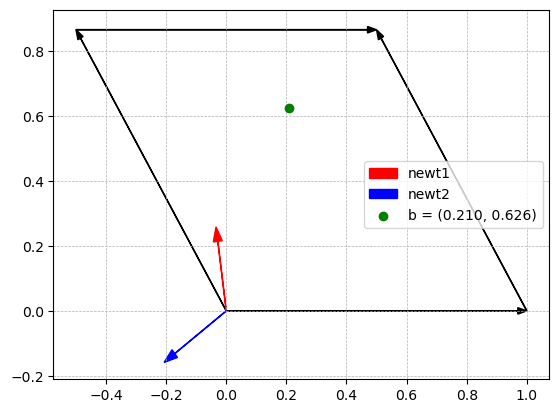

In [124]:
fig, ax = plt.subplots()

b = random_point_in_third_hexagon(orig_v1, orig_v2)

# 1/3 of hexagon
ax.arrow(0, 0, *orig_v1, length_includes_head=True, head_width=0.02, color='black')
ax.arrow(0, 0, *orig_v2, length_includes_head=True, head_width=0.02, color='black')
ax.arrow(orig_v2[0], orig_v2[1], *orig_v1, length_includes_head=True, head_width=0.02, color='black')
ax.arrow(orig_v1[0], orig_v1[1], *orig_v2, length_includes_head=True, head_width=0.02, color='black')
# new translation vectors
ax.arrow(0,0, *newt1, length_includes_head=True, head_width=0.03, color='red',   label='newt1')
ax.arrow(0,0, *newt2, length_includes_head=True, head_width=0.03, color='blue',  label='newt2')


ax.scatter(*b, color='green', zorder=5, label=f'b = ({b[0]:.3f}, {b[1]:.3f})')

ax.set_aspect('auto')
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.legend()
plt.show()

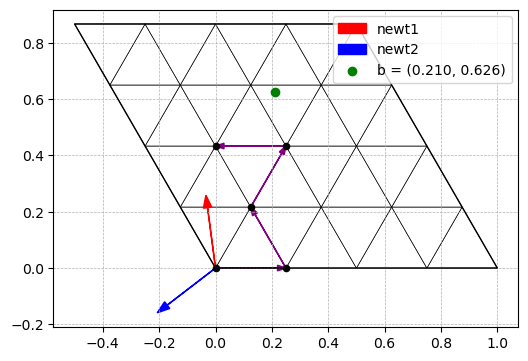

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

# Define vectors and subdivision
m = 4
orig_v1 = np.array([1.0, 0.0])
orig_v2 = np.array([-0.5, np.sqrt(3)/2])

# Subdivision function (equilateral via short diagonal)
def subdivide_rhombus(m, v1, v2):
    points = [[(i/m)*v1 + (j/m)*v2 for j in range(m+1)] for i in range(m+1)]
    triangles = []
    for i in range(m):
        for j in range(m):
            p00 = points[i][j]
            p10 = points[i+1][j]
            p01 = points[i][j+1]
            p11 = points[i+1][j+1]
            # cut along short diagonal p00 -> p11
            triangles.append([p00, p10, p11])
            triangles.append([p00, p11, p01])
    return triangles

# Rotation utility
def rotate_vector(vec, angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, -s], [s, c]]) @ vec

# Serpent path with fixed rotations
def serpent_rotations_fixed(start_point, m, v1):
      # common step length
    L = np.linalg.norm(v1) / m
    # base unit direction
    d0 = v1 / np.linalg.norm(v1)
    
    p = [np.array(start_point)]
    # 1) 0°
    d1 = d0
    p.append(p[-1] + d1*L)
    # 2) +120°
    d2 = rotate_vector(d0, 2*np.pi/3)
    p.append(p[-1] + d2*L)
    # 3) +60° from d0
    d3 = rotate_vector(d0, np.pi/3)
    p.append(p[-1] + d3*L)
    # 4) +180° from d0
    d4 = rotate_vector(d0, np.pi)
    p.append(p[-1] + d4*L)
    return p

# Compute path and lengths
path = serpent_rotations_fixed([0,0], m, orig_v1)

# Plot triangles
triangles = subdivide_rhombus(m, orig_v1, orig_v2)
fig, ax = plt.subplots(figsize=(6,6))
poly = PolyCollection(triangles, edgecolors='black', facecolors='white', linewidths=0.5)
ax.add_collection(poly)
boundary = np.array([[0,0], orig_v1, orig_v1+orig_v2, orig_v2, [0,0]])
ax.plot(boundary[:,0], boundary[:,1], 'k-', linewidth=1)
ax.grid(True, linestyle='--', linewidth=0.5)

# Plot serpent arrows
for i in range(len(path)-1):
    s, e = path[i], path[i+1]
    delta = e - s
    ax.arrow(s[0], s[1], delta[0], delta[1],
             length_includes_head=True, head_width=0.02, color='purple')

# Scatter points
ax.scatter(*zip(*path), color='black', s=20, zorder=5)

ax.arrow(0,0, *newt1, length_includes_head=True, head_width=0.03, color='red',   label='newt1')
ax.arrow(0,0, *newt2, length_includes_head=True, head_width=0.03, color='blue',  label='newt2')


ax.scatter(*b, color='green', zorder=5, label=f'b = ({b[0]:.3f}, {b[1]:.3f})')

ax.legend()

ax.set_aspect('equal')
plt.show()
